# CNN autoencoder

## 1. Imports, functions and constants

In [1]:
from CNN import *
from GradCAMUtils import *
from Utils_auto import *
from Autoencoder import *

In [2]:
"""Constants"""
# sequence length indicate the maximum length for all of the sequnence 626/798
SEQUENCE_LENGTH = 798

BATCH_SIZE = 16

vocab = {'C': [0,0,1], 'H': [0,1,0], 'E': [1,0,0], '-':[0,0,0]}

# Transform the labels from String to Integer via LabelEncoder
le_fold = preprocessing.LabelEncoder()
le_fam = preprocessing.LabelEncoder()

# torch.cuda.set_device()
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

cuda_gpu = torch.cuda.is_available()   #check if gpu is avaliable

torch.cuda.empty_cache()

## 2. Load dataset and models

In [3]:
# load pretrained final model
model = pickle.load(open("../PretrainedModels/CNNAttention.pickle", 'rb'))

In [4]:
# load data
df = pd.read_csv("../Datasets/Training_data/gt_training.autoencoder.csv")

train_df, test_df, val_df =  Train_Test_Val_split(df)

df_gtu = pd.read_csv("../Datasets/gtu/gtu.processed.csv")

Train_ds, Train_dl = Dataset_Loader(train_df, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

Val_ds, Val_dl = Dataset_Loader(val_df, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

Test_ds, Test_dl = Dataset_Loader(test_df, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

Val_u_ds, Val_u_dl = Dataset_Loader(df_gtu, le_fam, le_fold, vocab, BATCH_SIZE=20, cuda = cuda_gpu)

19912 2490 2490


In [5]:
df_A = df.loc[df["fold"]=="A"]
df_B = df.loc[df["fold"]=="B"]
df_C = df.loc[df["fold"]=="C"]
df_Lyso = df.loc[df["fold"]=="lyso"]

## 3. Model training

/home/zzl/anaconda3/envs/GT_test/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch :1 	Training Loss :13.281939.
Epoch :1 	Val Loss :8.171213.
Epoch :1 	Val OOD Loss :7.328009.
Validation loss decreased (inf --> 8.171213).  Saving model ...


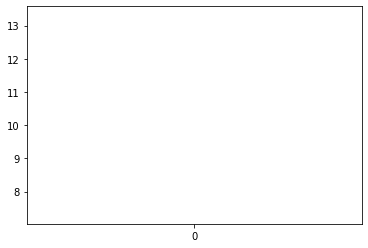

In [6]:
# training the model
model_autoencoder = autoencoder(model).cuda()
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_autoencoder.parameters()), lr=1e-5)

model_A = fit_autoencoder(1, model_autoencoder, criterion, optimizer, Train_dl, Val_dl, Val_u_dl, patience=1)

In [ ]:
def save_rerr(df, le_fam, le_fold, vocab, BATCH_SIZE=1, cuda=cuda_gpu, model, name):
    reconstruction_err = []
    for i, data in enumerate(Train_dl, 0):
        model_A.eval()

        xb, yb, p = data
        output = model(xb)
        xb = xb.float()
        loss = criterion(output, xb)/(p.sum())

        reconstruction_err.append([df.iloc[i].family, loss.item()])

    return pd.DataFrame(reconstruction_err, columns=["fold", "Err"]).to_csv(name, index=False)

In [ ]:
save_rerr(df=df, le_fam=le_fam, le_fold=le_fold, vocab=vocab, BATCH_SIZE=1, cuda=cuda_gpu, model, name)